## 1. Provide Flight Plan arinc633 XML file

In [99]:
#filename_input = "AAY_Test/AAY-1142-121100z-KPIT-R03-arinc633"  # has contrails
filename_input = "AAY_Test/AAY-1145-112136z-KPIT-R01-arinc633"

## 2. Set Default Params

In [100]:
#defaults
engine_efficiency_input = 0.45
non_volatile_emissions_index_input =  1500000000000000 
n_engine_input = 2
thrust_setting_input = 0.22  

wingspan_dict = {
  "A320": 37.57,
  "B737": 36.0,
  "A350": 65,
  "A380": 80
}

## 3. Process Flight Data

In [101]:
import xml.etree.ElementTree as et 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta

from pycontrails import Flight, Aircraft
from pycontrails.datalib.ecmwf import ERA5
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import ConstantHumidityScaling

xtree = et.parse("./data/" + filename_input + ".xml" )
xroot = xtree.getroot()

#M633 Supplementary Header
header_s_633 = xroot[1]
flight_origin_date = header_s_633[0].get('flightOriginDate')
flight_number = header_s_633[0][0][1][0].text 
dep_airport_name = header_s_633[0][1].get('airportName')
arr_airport_name = header_s_633[0][2].get('airportName')

aircraft_reg = header_s_633[1].get('aircraftRegistration')
aircraft_subtype = header_s_633[1][0].get('airlineSpecificSubType')
aircraft_model = header_s_633[1][0][0].text  

#M633 FlightInfo
flight_info = xroot[2]
aircraft_reg = header_s_633[1].get('aircraftRegistration')
call_sign = flight_info.get('aTCCallsign')

#M633 FlightPlan Header
flight_plan_header = xroot[4]

performance_factor = flight_plan_header[1].text # ('PerformanceFactor')
fuel_flow_avg = flight_plan_header[2][0][0].text
fuel_flow_holding = flight_plan_header[2][1][0].text
fms_route_name = flight_plan_header[3].get('fMSRouteName') #.text
route_name = flight_plan_header[3].get('routeName')
wind_direction_avg = flight_plan_header[3][0][0][0].text
wind_speed_avg = flight_plan_header[3][0][1][0].text
ground_distance = flight_plan_header[3][9][0].text
air_distance = flight_plan_header[3][10][0].text
greatcircle_distance = flight_plan_header[3][11][0].text

#M633 Weight Header
weight_header = xroot[6]
takeoff_weight = int(weight_header[3][0][0].text)#/2.205
landing_weight = int(weight_header[4][0][0].text)#/2.205
burn = int(takeoff_weight) - int(landing_weight)

# Waypoints
waypoints = xroot[7]
df_cols = ["sequence_no", "waypoint_name", 
           "latitude", "longitude", 
           "altitude", "elapsed_time", 
          # "mach_number", 
           "true_airspeed", 
           #"indicated_airspeed",
           "engine_efficiency", "time", "burn_off", "c"]
rows = []

for wp in waypoints:
#for wp in xroot.iter('Waypoint'): 
    sequence_no = int(wp.get('sequenceId'))
    waypoint_name = wp.get('waypointName')
    lat = float(wp[0].get('latitude'))/3600
    long = float(wp[0].get('longitude'))/3600
    altitude, burn_off, fuel_flow, mach_number, true_airspeed, indicated_airspeed = 0.0,0.0, 0.0, 0.0, 0.0, 0.0
    seconds = 0
    timestamp = '2023-05-23T04:36:00' # datetime.today()
    date_format = '%Y-%m-%dT%H:%M:%S'
    altitude = None

    for child in wp:
        if child.tag == '{http://aeec.aviation-ia.net/633}Altitude':
            altitude = (float(child[0][0].text)*100)/3.218  if child[0][0] is not None else 0
        if child.tag == '{http://aeec.aviation-ia.net/633}BurnOff':
            burn_off = float(child[0][0].text) #/2.205
        if child.tag == '{http://aeec.aviation-ia.net/633}TimeOverWaypoint':
            timestamp = child[0][0].text
            #print(timestamp)
        if child.tag == '{http://aeec.aviation-ia.net/633}TimeFromPreviousWaypoint':
            split = child[0][0].text.split("H")
            minutes = split[1] 
            seconds = float(minutes.split("M")[0])*60
            #else:
            #    fuel_flow = 0
            #time = time - timedelta(days=13)
        if child.tag == '{http://aeec.aviation-ia.net/633}MachNumber':
            mach_number = float(child[0][0].text) # if mach_no_node is not None else 0
        if child.tag == '{http://aeec.aviation-ia.net/633}TrueAirSpeed':
            true_airspeed = float(child[0][0].text)*0.514 # if mach_no_node is not None else 0
        if child.tag == '{http://aeec.aviation-ia.net/633}IndicatedAirSpeed':
            indicated_airspeed = float(child[0][0].text)*0.514 # if mach_no_node is not None else 0

    rows.append({"sequence_no": sequence_no,
             "waypoint_name": waypoint_name,
             "latitude": lat,
             "longitude": long, 
             "altitude": altitude,
             "elapsed_time": seconds, 
             "time": timestamp, #datetime.strptime(timestamp, date_format) , 
             "burn_off": burn_off,
             #"mach_number": mach_number,
             "true_airspeed": true_airspeed, 
            #"indicated_airspeed": indicated_airspeed,
             "engine_efficiency": 0.0
            })

# Set Takeoff Weight 
rows[0]['c'] = takeoff_weight
# Set Initial Altitude
rows[0]['altitude'] =0
# Set Final Altitude
rows[len(rows)-1]['altitude']=0

out_df = pd.DataFrame(rows, columns = df_cols)
#out_df.info()
new_col = 'c'

def apply_func_decorator(func):
    prev_row = {}
    def wrapper(curr_row, **kwargs):
        val = func(curr_row, prev_row)
       # print(val)
       # print(prev_row)
        prev_row.update(curr_row)
       # print(prev_row)
        prev_row[new_col] = val
       # print(prev_row)
       # print(val)
        return val
    return wrapper

@apply_func_decorator
def aircraft_mass(curr_row, prev_row):
    #print(curr_row)
    #print(prev_row)
    return prev_row.get("c", takeoff_weight) - curr_row["burn_off"]

#+ curr_row['b'] + prev_row.get('c', 0)
out_df["aircraft_mass"] = out_df.apply(aircraft_mass, axis=1)

# fuel flow 
#"Fuel mass flow rate (kg s-1)": "fuel_flow",
#Kilogram Per Second (kg/s) is a unit in the category of Mass flow rate. 
#It is also known as kilogram/second, kilograms per second. 
#This unit is commonly used in the SI unit system. Kilogram Per Second (kg/s) has a dimension of MT-1 where M is mass, and T is time.

def fuel_flow(df):
    if df["burn_off"] > 0 and df["elapsed_time"] > 0:
        return df["burn_off"] / df["elapsed_time"]
    else:
        return 0

out_df["fuel_flow"] = out_df.apply(fuel_flow, axis=1)

# Engine Efficiency

F=0.22  # Thrust 
Q=43.24  # 

def engine_efficiency(df):
    V = int(df["indicated_airspeed"])*0.514
    fuel_flow = df["fuel_flow"]
    if V > 0 and fuel_flow > 0:
        efficiency = (F*V)/(Q*fuel_flow)
        return efficiency
    else:
        return 0

out_df["engine_efficiency"] =  engine_efficiency_input # out_df.apply(engine_efficiency, axis=1)

#out_df.info()
out_df = out_df.drop('c', axis=1)
cleaned_df = out_df.drop_duplicates(subset='time', keep="first")
#cleaned_df = cleaned_df[cleaned_df.altitude != 0]

#cleaned_df.describe()
# max_altitude = ?
# max_speed = ? 

# demo synthetic flight

flight_attrs = {
    "flight_id": call_sign,
    # set constants along flight path
    #"true_airspeed": true_airspeed_input, 
    "thrust": thrust_setting_input, 
    "nvpm_ei_n": non_volatile_emissions_index_input,
}
df = cleaned_df.interpolate(method='linear', limit_direction='forward', axis=0)
df = df.fillna(0)

#print(flight_attrs)
# wingspan_dictionary =
wingspan_input = 37.57  
if aircraft_model in wingspan_dict:
    wingspan_input =  wingspan_dict[aircraft_model]

aircraft = Aircraft(aircraft_type=aircraft_model, wingspan=wingspan_input, n_engine=n_engine_input)
flight = Flight(df, aircraft=aircraft, attrs=flight_attrs)


In [102]:
cleaned_df

,sequence_no,waypoint_name,latitude,longitude,altitude,elapsed_time,true_airspeed,engine_efficiency,time,burn_off,aircraft_mass,fuel_flow
0,0,KPIT,40.491667,-80.233333,0.000000,0.0,0.000,0.45,2023-06-11T21:48:00,0.0,158145.0,0.000000
1,1,CKB,39.253333,-80.268333,NaN,840.0,0.000,0.45,2023-06-11T22:02:00,3022.0,155123.0,3.597619
2,2,KZDC,39.166667,-80.325000,NaN,60.0,0.000,0.45,2023-06-11T22:03:00,123.0,155000.0,2.050000
3,3,KZID,38.836667,-80.540000,NaN,180.0,0.000,0.45,2023-06-11T22:06:00,465.0,154535.0,2.583333
4,4,TOC,38.231667,-80.928333,NaN,360.0,0.000,0.45,2023-06-11T22:12:00,854.0,153681.0,2.372222
5,5,KZTL,37.100000,-81.635000,10565.568676,660.0,236.440,0.45,2023-06-11T22:23:00,1146.0,152535.0,1.736364
6,6,KT39S,36.500000,-82.000000,10565.568676,360.0,236.440,0.45,2023-06-11T22:29:00,607.0,151928.0,1.686111
7,7,ODF,34.696667,-83.298333,10565.568676,1140.0,236.954,0.45,2023-06-11T22:48:00,1864.0,150064.0,1.635088
8,8,MCN,32.691667,-83.646667,10565.568676,960.0,235.926,0.45,2023-06-11T23:04:00,1643.0,148421.0,1.711458
9,9,KZJX,31.745000,-83.015000,10876.320696,540.0,234.898,0.45,2023-06-11T23:13:00,850.0,147571.0,1.574074


In [103]:
df = cleaned_df.interpolate(method='linear', limit_direction='forward', axis=0)
df = df.fillna(0)
df.describe()

,sequence_no,latitude,longitude,altitude,elapsed_time,true_airspeed,engine_efficiency,burn_off,aircraft_mass,fuel_flow
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,2.200000e+01,22.000000,22.000000,22.000000
mean,10.500000,32.576970,-82.007727,6921.294988,340.909091,85.651091,4.500000e-01,602.681818,148822.181818,1.354275
std,6.493587,4.499406,0.963809,3956.136341,319.313387,115.973617,1.704524e-16,759.819614,4228.850228,0.885714
min,0.000000,27.908333,-83.646667,0.000000,0.000000,0.000000,4.500000e-01,0.000000,144886.000000,0.000000
25%,5.250000,28.665000,-82.372917,3853.325047,75.000000,0.000000,4.500000e-01,60.500000,145501.250000,0.586667
50%,10.500000,30.420833,-82.257500,7955.251709,240.000000,0.000000,4.500000e-01,366.000000,146393.000000,1.604581
75%,15.750000,36.950000,-81.726250,10565.568676,510.000000,234.769500,4.500000e-01,853.000000,152383.250000,1.770202
max,21.000000,40.491667,-80.233333,11187.072716,1140.000000,236.954000,4.500000e-01,3022.000000,158145.000000,3.597619


In [104]:
df

,sequence_no,waypoint_name,latitude,longitude,altitude,elapsed_time,true_airspeed,engine_efficiency,time,burn_off,aircraft_mass,fuel_flow
0,0,KPIT,40.491667,-80.233333,0.000000,0.0,0.000,0.45,2023-06-11T21:48:00,0.0,158145.0,0.000000
1,1,CKB,39.253333,-80.268333,2113.113735,840.0,0.000,0.45,2023-06-11T22:02:00,3022.0,155123.0,3.597619
2,2,KZDC,39.166667,-80.325000,4226.227470,60.0,0.000,0.45,2023-06-11T22:03:00,123.0,155000.0,2.050000
3,3,KZID,38.836667,-80.540000,6339.341206,180.0,0.000,0.45,2023-06-11T22:06:00,465.0,154535.0,2.583333
4,4,TOC,38.231667,-80.928333,8452.454941,360.0,0.000,0.45,2023-06-11T22:12:00,854.0,153681.0,2.372222
5,5,KZTL,37.100000,-81.635000,10565.568676,660.0,236.440,0.45,2023-06-11T22:23:00,1146.0,152535.0,1.736364
6,6,KT39S,36.500000,-82.000000,10565.568676,360.0,236.440,0.45,2023-06-11T22:29:00,607.0,151928.0,1.686111
7,7,ODF,34.696667,-83.298333,10565.568676,1140.0,236.954,0.45,2023-06-11T22:48:00,1864.0,150064.0,1.635088
8,8,MCN,32.691667,-83.646667,10565.568676,960.0,235.926,0.45,2023-06-11T23:04:00,1643.0,148421.0,1.711458
9,9,KZJX,31.745000,-83.015000,10876.320696,540.0,234.898,0.45,2023-06-11T23:13:00,850.0,147571.0,1.574074


## 4. Load Meteorological Data from Copernicus

ERA5 is the fifth generation ECMWF atmospheric reanalysis of the global climate covering the period from January 1940 to present. ERA5 is produced by the Copernicus Climate Change Service (C3S) at ECMWF.

ERA5 provides hourly estimates of a large number of atmospheric, land and oceanic climate variables. The data cover the Earth on a 30km grid and resolve the atmosphere using 137 levels from the surface up to a height of 80km. ERA5 includes information about uncertainties for all variables at reduced spatial and temporal resolution

ERA5 combines vast amounts of historical observations into global estimates using advanced modelling and data assimilation systems.s.

In [105]:
time = (
    pd.to_datetime(flight["time"][0]).floor("H"),
    pd.to_datetime(flight["time"][-1]).ceil("H"), #+ pd.Timedelta("10H"),
)
print(time)
pressure_levels = [200,300,250,400,500,600]

era5pl = ERA5(
    time=time,
    variables=Cocip.met_variables + Cocip.optional_met_variables,
    pressure_levels=pressure_levels,
)
era5sl = ERA5(time=time, variables=Cocip.rad_variables)

met = era5pl.open_metdataset()
rad = era5sl.open_metdataset()

print("Done getting Met data")

(Timestamp('2023-06-11 21:00:00'), Timestamp('2023-06-12 00:00:00'))
Done getting Met data


## Evaluate COCIP model

- A contrail cirrus prediction (COCIP) model
- 
U. Schumann- . A new model to simulate and predict the properties of a large ensemble of contrails as a function of given air traffic and meteorology is described. The model is designed for approximate prediction of contrail cirrus cover and analysis of contrail climate impact, e.g. within aviation system optimization processes. The model simulates the full contrail life-cycl
- . Contrail segments form between waypoints of individual aircraft tracks in sufficiently cold and humid air masses. The initial contrail properties depend on the aircraf
- . The simple model reproduces a considerable part of observed contrail properties. Mid-aged contrails provide the largest contributions to the product of optical depth and contrail width, important for climate impact.

In [106]:
params = {
    "process_emissions": False,
    "verbose_outputs": True,
  #  "dt_integration": np.timedelta64(10, "m"),
    "humidity_scaling": ConstantHumidityScaling(rhi_adj=0.98), 
}
cocip = Cocip(met=met, rad=rad, params=params)

#print(params)
#print(cocip)

#flight = flight.resample_and_fill(freq='5T', drop=False)

fl_out = cocip.eval(source=flight)
#fl_out.dataframe.info()

flight_statistics = cocip.output_flight_statistics()

f = fl_out.dataframe
fuel_burn = f['burn_off'].sum()
avg_fuel_flow = f['fuel_flow'].mean()
max_true_airspeed = f['true_airspeed'].max()
max_altitude = f['altitude'].max()
num_waypoints = len(f)
departure_time = f.loc[0]['time']
arrival_time = f.loc[len(f)-1]['time']
duration_seconds = arrival_time - departure_time
duration_minutes = duration_seconds.total_seconds() / 60

bc_ei_n = flight_statistics['BC EI_n mean (kg-1)']
total_contrail_EF = flight_statistics['Total contrail EF (J)']
short_lived_contrails = flight_statistics['Short-lived contrails']
initial_contrail_length_km = flight_statistics['Initial contrail length (km)']
persistent_contrails = flight_statistics['Persistent contrails']
persistent_contrail_length_km = flight_statistics['Persistent contrail length (km)']
rhi_life_mean = flight_statistics['RHi lifetime, Mean']
tau_contrail_mean = flight_statistics['Tau contrail, Mean']
sdr_mean_w = flight_statistics['SDR mean (W m-2)']
rsr_mean_w = flight_statistics['RSR mean (W m-2)']
olr_mean_w = flight_statistics['OLR mean (W m-2)']

C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\cocip.py:588: UserWarning:Flight trajectory has segment lengths close to or exceeding the 'max_seg_length_m' parameter. Evolved contrail segments may reach their end of life artificially early. Either resample the flight with the 'resample_and_fill' method (recommended), or use a larger 'max_seg_length_m' parameter. Current values: max_seg_length_m=40000.0, max_seg_length_on_trajectory=232356.77842273153
C:\Users\zaki.patel\AppData\Local\Programs\Python\Python311\Lib\site-packages\pycontrails\models\cocip\contrail_properties.py:444: UserWarning:All tau_contrail values are nan. This may be due to waypoints all lying outside of the met interpolation grid. It could indicate an issue with interpolation, or an insufficient met domain.


## 5. Results

In [107]:
print("FLIGHT INFO") 
print("------------")
print("ATC Call Sign: ", call_sign) 
print("Flight No: ", flight_number)
print("Flight Origin Date: " , flight_origin_date)
print("Departure:", dep_airport_name)
print("Departure Time:", departure_time)
print("Arrival Time:", arrival_time)
print("Arrival:", arr_airport_name)
print("Route Name:" , fms_route_name, "(", route_name ,")" )
print("Flight Duration (mins): " , duration_minutes)
print("Distance (NM) - Ground: ", ground_distance, " Air: ", air_distance, " Great Circule: ", greatcircle_distance) 
print("Wind Direction Avg (Deg):", wind_direction_avg, "Wind Direction Speed (Kt):", wind_speed_avg)
print("Weight - Take Off (Kgs):", int(takeoff_weight), "Weight - Landing (Kgs):", int(landing_weight))
print("Fuel Burn (Kgs)", burn, "Performance Factor:" , performance_factor)
print("Fuel Flow Avg (Lb/h):" , fuel_flow_avg, "Fuel Flow Holding (Lb/h):" , fuel_flow_holding)
print("Aircraft Reg: " , aircraft_reg) 
print("Aircraft Model: " , aircraft_model)
print("Aircraft SubType: " , aircraft_subtype) 
print("Performance Factor: " , performance_factor) 

print("Fuel Burn (kg): " ,fuel_burn)
print("Avg Fuel Flow: ", avg_fuel_flow)
print("Max True AirSpeed: ", max_true_airspeed)
print("Max Altitude: ", max_altitude)
print("Waypoints: ", num_waypoints)
print("------------")
print("CALCUATION")
print("------------")
print("Initial Contrail (Km): "  , initial_contrail_length_km) 
print("Persistent Contrail (Km): "  , persistent_contrail_length_km) 
print("Total Contrail EF (J): "  , total_contrail_EF) 
print("BC EI_n mean (kg-1): ", bc_ei_n)
print("RHi lifetime, Mean: ", rhi_life_mean)
print("Tau Contrail Mean: ", tau_contrail_mean)
print("SDR Mean W(M-2): " , sdr_mean_w) 
print("RSR Mean W(M-2): " , rsr_mean_w)
print("OLR Mean W(M-2): " , olr_mean_w)

FLIGHT INFO
------------
ATC Call Sign:  AAY1145
Flight No:  G41145
Flight Origin Date:  2023-06-11
Departure: PITTSBURGH INTL
Departure Time: 2023-06-11 21:48:00
Arrival Time: 2023-06-11 23:53:00
Arrival: ST PETE-CLEARWATER INTL
Route Name: KPITKPIEMAN ( MAN )
Flight Duration (mins):  125.0
Distance (NM) - Ground:  821  Air:  872  Great Circule:  765
Wind Direction Avg (Deg): 237 Wind Direction Speed (Kt): 041
Weight - Take Off (Kgs): 158145 Weight - Landing (Kgs): 144886
Fuel Burn (Kgs) 13259 Performance Factor: 1.056
Fuel Flow Avg (Lb/h): 6048 Fuel Flow Holding (Lb/h): 5493
Aircraft Reg:  N295NV
Aircraft Model:  A320
Aircraft SubType:  A320 214C CFM56-5B43
Performance Factor:  1.056
Fuel Burn (kg):  13259.0
Avg Fuel Flow:  1.3542754764839093
Max True AirSpeed:  236.954
Max Altitude:  11187.072715972654
Waypoints:  22
------------
CALCUATION
------------
Initial Contrail (Km):  684.9878569679241
Persistent Contrail (Km):  564.203150273335
Total Contrail EF (J):  0.0
BC EI_n mean (kg-

## 6. Flight Statistics

A curated set of statistics available after a Flight has been run through eval



In [124]:
flight_statistics

Flight ID                                                      AAY1145
ATYP                                                              A320
First wypt                               2023-06-11T21:48:00.000000000
Last wypt                                2023-06-11T23:53:00.000000000
Total flight dist (km)                                     1520.691007
Total fuel burn (kg)                                      10643.044366
OPE mean                                                          0.45
Fuel methodology                                                  None
ATYP assumed                                                      None
Engine name                                                       None
Aircraft mass mean (kg)                                  148822.181818
BC EI_n mean (kg-1)                                 1500000000000000.0
BC methodology                                                    None
Short-lived contrails                                             True
Initia

# 7. Output 
- The output_flight object holds roughly 50 variables of interest. 
- The energy forcing ef field is a primary model output
- Waypoints not producing persistent contrails are assigned an ef value of 0.

In [109]:
df = fl_out.dataframe  # cocip.source.dataframe is equivalent
df.head()

,waypoint,sequence_no,waypoint_name,latitude,longitude,altitude,elapsed_time,true_airspeed,engine_efficiency,burn_off,...,rf_sw_min,rf_sw_max,rf_lw_mean,rf_lw_min,rf_lw_max,rf_net_mean,rf_net_min,rf_net_max,cocip,time
0,0,0,KPIT,40.491667,-80.233333,0.000000,0.0,0.0,0.45,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2023-06-11 21:48:00
1,1,1,CKB,39.253333,-80.268333,2113.113735,840.0,0.0,0.45,3022.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2023-06-11 22:02:00
2,2,2,KZDC,39.166667,-80.325000,4226.227470,60.0,0.0,0.45,123.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2023-06-11 22:03:00
3,3,3,KZID,38.836667,-80.540000,6339.341206,180.0,0.0,0.45,465.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2023-06-11 22:06:00
4,4,4,TOC,38.231667,-80.928333,8452.454941,360.0,0.0,0.45,854.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,2023-06-11 22:12:00


In [110]:
df.info() 

<class 'lux.core.frame.LuxDataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 68 columns):
 #   Column                            Non-Null Count  Dtype          
---  ------                            --------------  -----          
 0   waypoint                          22 non-null     int32          
 1   sequence_no                       22 non-null     int64          
 2   waypoint_name                     22 non-null     object         
 3   latitude                          22 non-null     float64        
 4   longitude                         22 non-null     float64        
 5   altitude                          22 non-null     float64        
 6   elapsed_time                      22 non-null     float64        
 7   true_airspeed                     22 non-null     float64        
 8   engine_efficiency                 22 non-null     float64        
 9   burn_off                          22 non-null     float64        
 10  aircraft_mass                     22 non

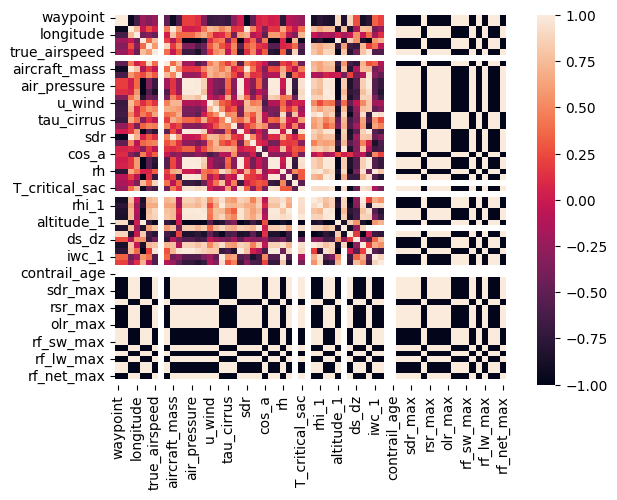

In [111]:
df = df.select_dtypes('number')
corr_matrix = df.corr()
#print(corr_matrix)
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(corr_matrix, annot=False)
plt.show()

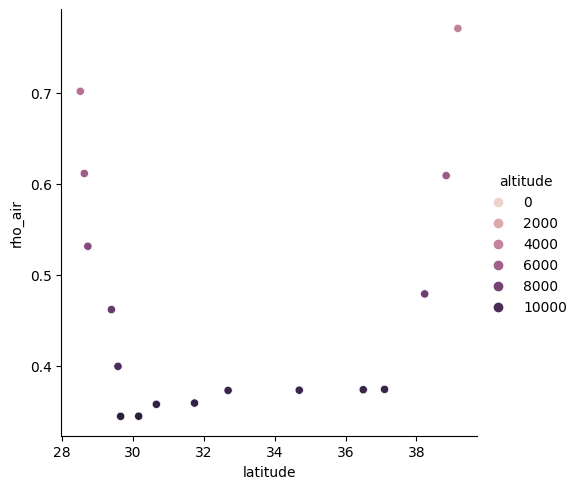

In [112]:
g = sn.relplot(kind='scatter', data=df, x='latitude', y='rho_air', hue='altitude') #, col='')

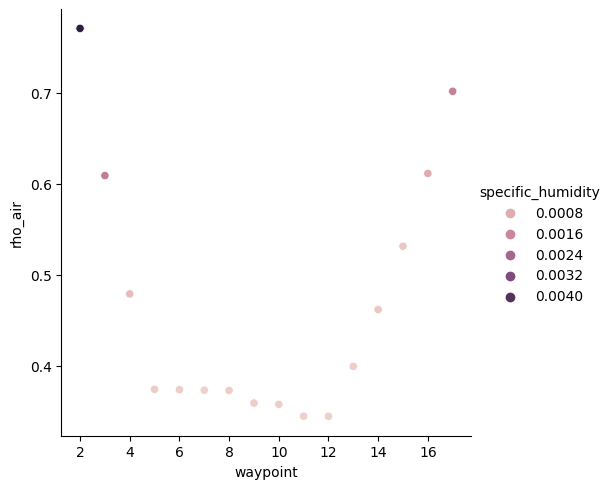

In [113]:
g = sn.relplot(kind='scatter', data=df, x='waypoint', y='rho_air', hue='specific_humidity')

## 8. Contrails

In [125]:
contrail = cocip.contrail
if contrail is not None: 
    contrail.info()
else:
    print("no contrail")

<class 'lux.core.frame.LuxDataFrame'>
Index: 6 entries, 0 to 1
Data columns (total 61 columns):
 #   Column                     Non-Null Count  Dtype          
---  ------                     --------------  -----          
 0   waypoint                   6 non-null      int32          
 1   flight_id                  6 non-null      object         
 2   formation_time             6 non-null      datetime64[ns] 
 3   time                       6 non-null      datetime64[ns] 
 4   age                        6 non-null      timedelta64[ns]
 5   longitude                  6 non-null      float64        
 6   latitude                   6 non-null      float64        
 7   altitude                   6 non-null      float64        
 8   level                      6 non-null      float64        
 9   continuous                 6 non-null      bool           
 10  segment_length             6 non-null      float64        
 11  sin_a                      6 non-null      float64        
 12  cos

In [131]:
#if contrail is not None: 
contrail_sub = contrail[['latitude', 'longitude', 'altitude', 'ef', 'age_hours', 'rf_net', 'persistent', 'dn_dt_turb', 'tau_contrail', 'n_ice_per_vol', 'plume_mass_per_m', 'top_net_thermal_radiation', 'rhi']]
contrail_sub

,latitude,longitude,altitude,ef,age_hours,rf_net,persistent,dn_dt_turb,tau_contrail,n_ice_per_vol,plume_mass_per_m,top_net_thermal_radiation,rhi
index,,,,,,,,,,,,,
0,36.512320,-81.989282,10512.323507,0.0,0.0,-8.784034,True,0.000065,0.269026,6.164784e+08,2698.410961,-192.726486,1.041536
0,36.881563,-81.666067,10543.186918,0.0,0.0,-3.940956,True,0.000016,0.377896,4.959677e+07,29130.396159,-198.288071,1.075196
0,37.245374,-81.303813,10619.407951,0.0,0.0,7.357091,True,0.000008,0.464989,1.661054e+07,80067.103552,-202.960037,1.034530
1,31.821955,-82.885934,10831.166515,0.0,0.0,2.991574,True,0.000022,0.524697,9.594229e+07,22339.765046,-157.688599,1.103510
0,37.599410,-80.907398,10756.135640,0.0,0.0,NaN,True,0.000006,0.721031,7.962517e+06,149512.839453,NaN,1.168581
1,31.972046,-82.676608,10883.550858,0.0,0.0,NaN,True,0.000009,0.446850,2.508653e+07,77699.807311,NaN,1.092371


In [127]:
if contrail is not None: 
    contrail_sub.describe()

In [132]:
contrail

,waypoint,flight_id,formation_time,time,age,longitude,latitude,altitude,level,continuous,...,rf_net,persistent,ef,timestep,age_hours,dt_integration,lon_edge_l,lat_edge_l,lon_edge_r,lat_edge_r
index,,,,,,,,,,,,,,,,,,,,,
0,6,AAY1145,2023-06-11 22:29:00,2023-06-11 22:30:00,0 days,-81.989282,36.512320,10512.323507,244.271742,False,...,-8.784034,True,0.0,0,0.0,0 days 00:01:00,-81.989282,36.512320,-81.989282,36.512320
0,6,AAY1145,2023-06-11 22:29:00,2023-06-11 23:00:00,0 days,-81.666067,36.881563,10543.186918,243.102324,False,...,-3.940956,True,0.0,1,0.0,0 days 00:30:00,-81.666067,36.881563,-81.666067,36.881563
0,6,AAY1145,2023-06-11 22:29:00,2023-06-11 23:30:00,0 days,-81.303813,37.245374,10619.407951,240.233712,False,...,7.357091,True,0.0,2,0.0,0 days 00:30:00,-81.303813,37.245374,-81.303813,37.245374
1,9,AAY1145,2023-06-11 23:13:00,2023-06-11 23:30:00,0 days,-82.885934,31.821955,10831.166515,232.407635,False,...,2.991574,True,0.0,2,0.0,0 days 00:17:00,-82.885934,31.821955,-82.885934,31.821955
0,6,AAY1145,2023-06-11 22:29:00,2023-06-12 00:00:00,0 days,-80.907398,37.599410,10756.135640,235.156609,False,...,NaN,True,0.0,3,0.0,0 days 00:30:00,-80.907398,37.599410,-80.907398,37.599410
1,9,AAY1145,2023-06-11 23:13:00,2023-06-12 00:00:00,0 days,-82.676608,31.972046,10883.550858,230.503855,False,...,NaN,True,0.0,3,0.0,0 days 00:30:00,-82.676608,31.972046,-82.676608,31.972046


## 11. Visualizations

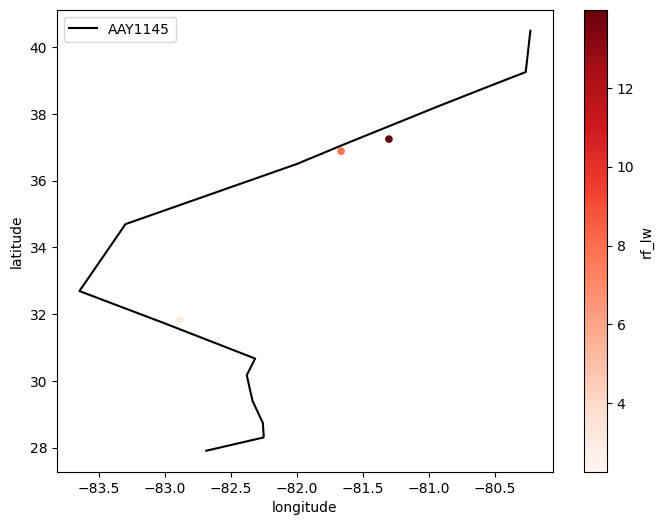

In [117]:
ax = cocip.source.dataframe.plot(
    "longitude", "latitude", color="k", label=fl_out.attrs["flight_id"], figsize=(8,6)
)
cocip.contrail.plot.scatter("longitude", "latitude", c="rf_lw", cmap="Reds", ax=ax);

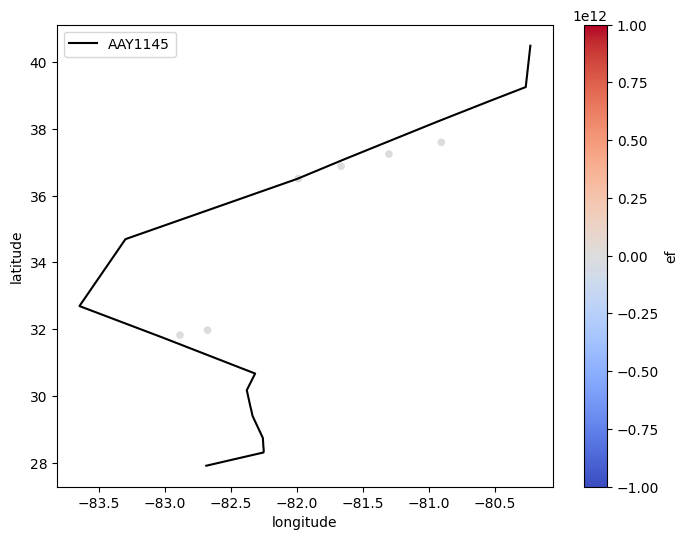

In [118]:
# We can visualize the contrail on top of the original flight trajectory 
ax = cocip.source.dataframe.plot(
    "longitude", "latitude", color="k", label=fl_out.attrs["flight_id"], figsize=(8, 6)
)
cocip.contrail.plot.scatter(
    "longitude", "latitude", c="ef", cmap="coolwarm", vmin=-1e12, vmax=1e12, ax=ax
);

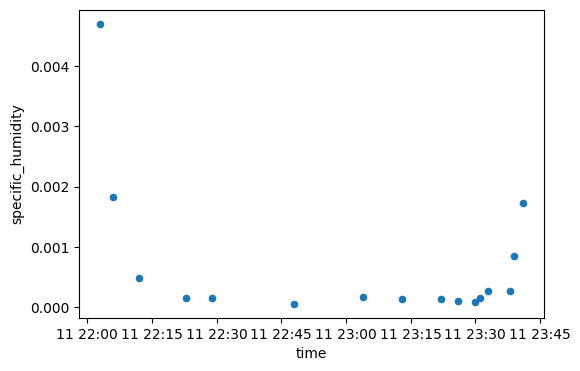

In [119]:
fl_out.dataframe.plot.scatter(x="time", y="specific_humidity", figsize=(6, 4));


## 13. Output contrail cirrus optical depth

In [120]:
from pycontrails.models.cocip.output import grid_cirrus

# get dataframe of contrail waypoints
df_contrails = cocip.contrail
df_contrails["flight_id"] = cocip.source.attrs["flight_id"]
w = df_contrails["longitude"].min()
e = df_contrails["longitude"].max()
s = df_contrails["latitude"].min()
n = df_contrails["latitude"].max()
bbox = [w, s, e, n]

# get required met data, and downselect within bounding box of contrails
cloud_cover = met["fraction_of_cloud_cover"].downselect(bbox).data
tau_cirrus = met["tau_cirrus"].downselect(bbox).data

# output summary for each timestep
grid_summary = grid_cirrus.cirrus_summary_statistics(
    df_contrails,
    cloud_cover,
    tau_cirrus,
)
grid_summary

,Total Cirrus Cover Pct,Natural Cirrus Cover Pct,Contrail Cirrus Cover Pct,Contrail Cirrus Cover Pct - Clear Sky
2023-06-11 21:00:00,66.882156,66.882156,0.0,0.0
2023-06-11 22:00:00,65.771975,65.771975,0.0,0.0
2023-06-11 23:00:00,51.047015,51.047015,0.0,0.0
2023-06-12 00:00:00,51.641293,51.641293,0.0,0.0


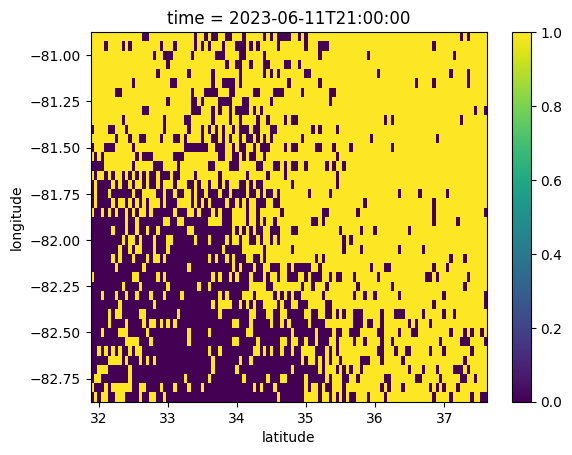

In [121]:
# natural cirrus cover
cc_natural, tau_natural = grid_cirrus._get_gridded_natural_cirrus_cover_and_tau(
    cloud_cover, tau_cirrus
)
cc_natural.isel(time=0).plot();

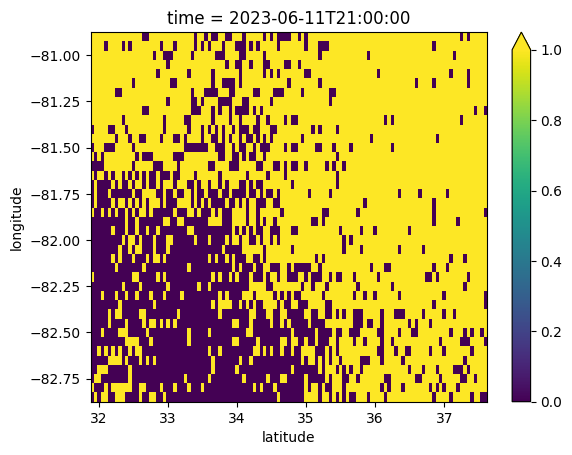

In [122]:
tau_natural.isel(time=0).plot(vmax=1);

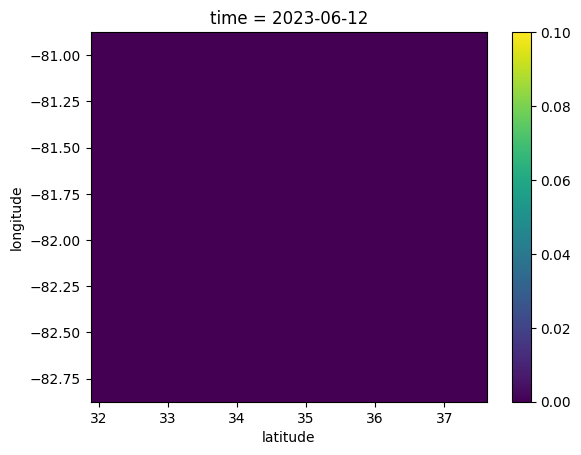

In [123]:
# optical depth of contrails
tau_contrails_clear = grid_cirrus.get_gridded_tau_contrail(df_contrails, cc_natural)
tau_contrails_clear.isel(time=len(grid_summary)-1).plot(vmax=0.1);